In [1]:
import numpy as np
from scipy import signal
import numbers
import errno
import os
import configparser
import sys
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim 
from torch.utils.data import DataLoader, TensorDataset

sys.path.append('..')

import matplotlib.pyplot as plt

In [46]:
def reshape_dataset_to_tensor(X, y=None, s=None, structure='static'):
    """numpyからtensorへの変換
    """
    X_tensor = torch.from_numpy(X).float()
    if structure == 'dynamic': # 時系列を考慮する変換
        X_tensor = torch.unsqueeze(X_tensor, dim=1)
    if y is not None:
        if s is not None:
            y_tensor = torch.from_numpy(y).long()
            s_tensor = torch.from_numpy(s).long()
            return TensorDataset(X_tensor, y_tensor, s_tensor)
        else:
            y_tensor = torch.from_numpy(y).long()
            return TensorDataset(X_tensor, y_tensor)
    else:
        return X_tensor
    
def normalize_train_data(X, type='norm', dim='whole'):
    """訓練データを正規化（標準化）する処理
    """
    stats = {}

    if dim == 'whole':
        stats['max'] = np.max(X)
        stats['mean'] = np.mean(X)
        stats['std'] = np.std(X)
    elif dim == 'each':
        stats['max'] = np.max(X, axis=0)
        stats['mean'] = np.mean(X, axis=0)
        stats['std'] = np.std(X, axis=0)

    if type == 'norm':
        X = X / stats['max']
    elif type == 'standard':
        X = (X - stats['mean']) / stats['std']
    
    return X, stats

In [3]:
n_channel = 4
n_class = 6
n_trial = 10
time_width = 45
down_sampling_rate = 10

In [47]:
stacked_data = np.empty((0, time_width, n_channel))
class_label = np.empty(0)
subject_label = np.empty(0)
select_subject = [0,1,2,3,4]
for s in select_subject:
    fname = f'./data/furui_lab/extracted/1.0Hz/sub{s+1}/'
    for c in range(n_class):
        # print(f'sub : {s+1} class_label : {c+1}')
        # stacked_data_trial = np.empty((0, time_width, n_channel))
        for t in range(n_trial):
            read_data = np.loadtxt(f'{fname}class{c+1}trial{t+1}.csv', usecols= [0,1,2,3],delimiter=',')
            # read_data = read_data[::down_sampling_rate]
            read_data = read_data.reshape(-1, time_width, n_channel)
            read_class_label = np.full(len(read_data),c)
            read_subject_label = np.full(len(read_data),s)
            
            stacked_data = np.vstack([stacked_data, read_data])
            class_label = np.hstack([class_label, read_class_label])
            subject_label = np.hstack([subject_label, read_subject_label])
        #     subject_label = np.hstack([subject_label, read_subject_label])

        #     # print(f'trial : {t+1} len : {len(read_data)}')

        #     stacked_data_trial = np.vstack([stacked_data_trial, read_data])

        # # stacked_data_trial = np.copy(stacked_data_trial[1:])

        # stacked_data = np.vstack([stacked_data, stacked_data_trial])
        # class_label = np.hstack([class_label, np.full(len(stacked_data_trial), c, dtype='int8')])
        # subject_label = np.hstack([subject_label, np.full(len(stacked_data_trial), s, dtype='int8')])
# stacked_data = stacked_data[1:]
# class_label = class_label[1:]
# subject_label = subject_label[1:]


In [48]:
print(stacked_data[0][1])
X, _ = normalize_train_data(stacked_data, 'norm', 'each')
print(X[0][1])
train_dataset = reshape_dataset_to_tensor(X, class_label, subject_label, 'static')

# dataset = TensorDataset(X, class_label, subject_label) 

data_loader = DataLoader(train_dataset, batch_size=256, 
              shuffle=True, drop_last=True)

[4.5584823e-05 2.4758065e-05 1.4494027e-04 1.3109583e-04]
[0.08053229 0.08410242 0.42538895 0.33725911]


In [6]:
print(len(train_dataset))
i = 0
for data, label,subject in data_loader:
    i +=1
    # print(data.size())
    # print(subject.size())
    # print(label.size())
print(i)
print(data.size())
print(len(data_loader.dataset))


84000
328
torch.Size([256, 45, 4])
84000


/Users/yoneda/envs/cuda_pytorch/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/yoneda/envs/cuda_pytorch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


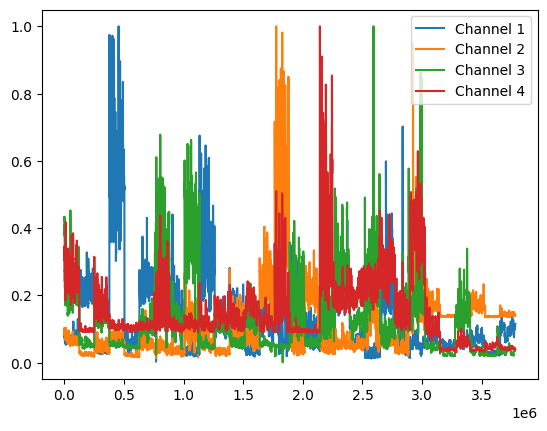

In [7]:
for d in range(n_channel):
    plt.plot(X.reshape(-1, 4)[:, d], label=f'Channel {d+1}')
plt.legend(ncol=1)

In [8]:
## 各モジュールの定義 
# Decoder  
# p(x|zx,zy,zd)
class px(nn.Module):
    def __init__(self, zd_dim, zx_dim, zy_dim, hidden_units, input_shape):
        super(px, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(zd_dim + zx_dim + zy_dim, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3 = nn.Linear(hidden_units, input_shape)

    def forward(self, zd, zx, zy):
        zdzxzy = torch.cat([zd, zx, zy], dim=1)
        h = self.fc1(zdzxzy)
        h = self.fc2(h)
        rec_x = self.fc3(h)
        return rec_x 

# p(zd|d)
class pzd(nn.Module):
    def __init__(self, d_dim, zd_dim):
        super(pzd, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(d_dim, zd_dim),
            nn.BatchNorm1d(zd_dim),
            nn.LeakyReLU()
        )
        self.fc2_mean = nn.Linear(zd_dim, zd_dim)
        self.fc2_logvar = nn.Sequential(nn.Linear(zd_dim, zd_dim, nn.Softplus()))
    
    def forward(self, d):
        h = self.fc1(d)
        zd_mean_prior = self.fc2_mean(h)
        zd_mean_prior = self.fc2_logvar(h)+1e-7
        return zd_mean_prior, zd_mean_prior
        
# p(zy|y)
class pzy(nn.Module):
    def __init__(self, y_dim, zy_dim):
        super(pzy, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(y_dim, zy_dim),
            nn.BatchNorm1d(zy_dim),
            nn.LeakyReLU()
        )
        self.fc2_mean = nn.Linear(zy_dim, zy_dim)
        self.fc2_logvar = nn.Sequential(nn.Linear(zy_dim, zy_dim, nn.Softplus()))
    
    def forward(self, y):
        h = self.fc1(y)
        zy_mean_prior = self.fc2_mean(h)
        zy_logvar_prior = self.fc2_logvar(h) + 1e-7
        return zy_mean_prior, zy_logvar_prior

# Encoder
# q(zd|x)
class qzd(nn.Module):
    def __init__(self, input_shape, hidden_units, zd_dim):
        super(qzd, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3_mean = nn.Linear(hidden_units, zd_dim)
        self.fc3_logvar = nn.Linear(hidden_units, zd_dim, nn.Softplus())
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        zd_mean = self.fc3_mean(h)
        zd_logvar = self.fc3_logvar(h) + 1e-7
        return zd_mean, zd_logvar

# q(zx|x)
class qzx(nn.Module):
    def __init__(self, input_shape, hidden_units, zx_dim):
        super(qzx, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3_mean = nn.Linear(hidden_units, zx_dim)
        self.fc3_logvar = nn.Linear(hidden_units, zx_dim, nn.Softplus())
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        zx_mean = self.fc3_mean(h)
        zx_logvar = self.fc3_logvar(h) + 1e-7
        return zx_mean, zx_logvar

# q(zy|x)
class qzy(nn.Module):
    def __init__(self, input_shape, hidden_units, zy_dim):
        super(qzy, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_units, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.LeakyReLU()
        )
        self.fc3_mean = nn.Linear(hidden_units, zy_dim)
        self.fc3_logvar = nn.Linear(hidden_units, zy_dim, nn.Softplus())
    
    def forward(self, x):
        h = self.fc1(x)
        h = self.fc2(h)
        zy_mean = self.fc3_mean(h)
        zy_logvar = self.fc3_logvar(h) + 1e-7
        return zy_mean, zy_logvar

# Auxiliary task
# q(d|zd)
class qd(nn.Module):
    def __init__(self, zd_dim, d_dim):
        super(qd, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(zd_dim, d_dim),
            nn.LeakyReLU()
        )
    
    def forward(self, zd):
        d_hat = self.fc1(zd)
        return d_hat

# q(y|zy)
class qy(nn.Module):
    def __init__(self, zy_dim, y_dim):
        super(qy, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(zy_dim, y_dim),
            nn.LeakyReLU()
        )
    
    def forward(self, zy):
        y_hat = self.fc1(zy)
        return y_hat

In [9]:
class DIVA(nn.Module):
    def __init__(self):
        super(DIVA, self).__init__()
        '''各zの次元数'''
        self.zd_dim = 2
        self.zx_dim = 2
        self.zy_dim = 2 
        '''被験者の数'''
        self.d_dim = 5
        '''クラス数'''
        self.y_dim = 6
        '''入力データの次元数'''
        self.input_shape = 180
        self.hidden_units = 256

        '''モジュールの定義'''
        self.px = px(zd_dim=self.zd_dim, zx_dim=self.zx_dim, zy_dim=self.zy_dim, hidden_units=self.hidden_units, input_shape=self.input_shape)

        self.pzd = pzd(d_dim=self.d_dim, zd_dim=self.zd_dim)
        self.pzy = pzy(y_dim=self.y_dim, zy_dim=self.zy_dim)

        self.qzd = qzd(input_shape=self.input_shape, hidden_units=self.hidden_units, zd_dim=self.zd_dim)
        self.qzx = qzx(input_shape=self.input_shape, hidden_units=self.hidden_units, zx_dim=self.zx_dim)
        self.qzy = qzy(input_shape=self.input_shape, hidden_units=self.hidden_units, zy_dim=self.zy_dim)

        self.qd = qd(zd_dim=self.zd_dim, d_dim=self.d_dim)
        self.qy = qy(zy_dim=self.zy_dim, y_dim=self.y_dim)
    
    def reparameterize(self, mean, logvar):
        '''Reparameterization trick'''
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, d, x, y):
        '''Encoder'''
        zd_mean, zd_logvar = self.qzd(x)
        zd = self.reparameterize(zd_mean, zd_logvar)
        zx_mean, zx_logvar = self.qzx(x)
        zx = self.reparameterize(zx_mean, zx_logvar)
        zy_mean, zy_logvar = self.qzy(x)
        zy = self.reparameterize(zy_mean, zy_logvar)
        '''Decoder'''
        rec_x = self.px(zd, zx, zy)
        zd_mean_prior, zd_logvar_prior = self.pzd(d)
        zd_prior = self.reparameterize(zd_mean_prior, zd_logvar_prior)
        zy_mean_prior, zy_logvar_prior = self.pzy(y)
        zy_prior = self.reparameterize(zy_mean_prior, zy_logvar_prior)
        '''Auxiliary task'''
        d_hat = self.qd(zd)
        y_hat = self.qy(zy)
        return {'recons' : rec_x, 'd_hat' : d_hat, 'y_hat' : y_hat, 'zd' : zd, 'zd_mean' : zd_mean, 'zd_logvar' : zd_logvar, 'zx' : zx, 'zx_mean' : zx_mean,
                'zx_logvar' : zx_logvar, 'zy' : zy, 'zy_mean' : zy_mean, 'zy_logvar' : zy_logvar, 'zd_prior' : zd_prior, 'zd_mean_prior' : zd_mean_prior, 'zd_logvar_prior' : zd_logvar_prior, 'zy_prior' : zy_prior,
                'zy_mean_prior' : zy_mean_prior, 'zy_logvar_prior' : zy_logvar_prior}
    
    def loss(self, input, d, y, output, kld_weight_zd=1, kld_weight_zy=1, kld_weight_zx=1):

        recons_loss = F.mse_loss(output['recons'], input, reduction='sum')

        kld_loss_zd = torch.sum(gaussian_loss(output['zd'], output['zd_mean'], output['zd_logvar'], output['zd_mean_prior'], output['zd_logvar_prior']),dim=0)
        kld_loss_zy = torch.sum(gaussian_loss(output['zy'], output['zy_mean'], output['zy_logvar'], output['zy_mean_prior'], output['zy_logvar_prior']),dim=0)
        kld_loss_zx = torch.sum(0.5 * torch.sum(1 + output['zx_logvar'] - output['zx_mean']**2 - output['zx_logvar'].exp(), dim = 1),dim=0)

        _, d_target = d.max(dim=1)
        _, y_target = y.max(dim=1)

        CE_d = F.cross_entropy(output['d_hat'], d_target, reduction= 'sum')
        CE_y = F.cross_entropy(output['y_hat'], y_target, reduction = 'sum')

        loss = recons_loss - kld_weight_zd * kld_loss_zd - kld_weight_zy * kld_loss_zy - kld_weight_zx * kld_loss_zx + CE_d + CE_y

        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'kl_zd': -kld_loss_zd.detach(), 'kl_zy' : -kld_loss_zy.detach(), 'kl_zx' : -kld_loss_zx.detach(), 'CE_d' : CE_d.detach(), 'CE_y' : CE_y.detach()}




def log_normal(x, mu, log_var):
      """Logarithm of normal distribution with mean=mu and variance=var
         log(x|μ, σ^2) = loss = -0.5 * Σ log(2π) + log(σ^2) + ((x - μ)/σ)^2

      Args:
         x: (array) corresponding array containing the input
         mu: (array) corresponding array containing the mean 
         var: (array) corresponding array containing the variance

      Returns:
         output: (array/float) depending on average parameters the result will be the mean
                                of all the sample losses or an array with the losses per sample
      """
      d = x.size(-1)
      return -d/2*np.log(2*np.pi)-1/2*torch.sum(log_var,1)-1/2*torch.sum((x-mu)**2/torch.exp(log_var),1)
    #   if self.eps > 0.0:
    #     var = var + self.eps
    #   return -0.5 * torch.sum(
    #     np.log(2.0 * np.pi) + 0.5*var + torch.pow(x - mu, 2) / torch.exp(var), dim=-1)


def gaussian_loss(z, z_mu, z_log_var, z_mu_prior, z_log_var_prior):
    """Variational loss when using labeled data without considering reconstruction loss
        loss = log p(z) - log q(z|x,y)

    Args:
        z: (array) array containing the gaussian latent variable
        z_mu: (array) array containing the mean of the inference model
        z_log_var: (array) array containing the variance of the inference model
        z_mu_prior: (array) array containing the prior mean of the generative model
        z_log_var_prior: (array) array containing the prior variance of the generative mode
        
    Returns:
        output: (array/float) depending on average parameters the result will be the mean
                            of all the sample losses or an array with the losses per sample
    """
    loss = log_normal(z, z_mu, z_log_var) - log_normal(z, z_mu_prior, z_log_var_prior)
#   print(f'gaussian_loss : {loss}')
    return -loss



In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DIVA().to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
n_epochs = 300


In [11]:
def train(epoch):
    model.train()
    
    total_loss = 0
    recon_loss = 0
    kld_zd = 0
    kld_zx = 0
    kld_zy = 0
    ce_d = 0
    ce_y = 0

    for batch_idx, (data, c_label, s_label) in enumerate(data_loader):
        data = data.to(device)
        data = data.view(-1, 45*4)
        c_label = c_label.to(device)
        s_label = s_label.to(device)
        c_label_onehot = F.one_hot(c_label, 6).float()
        s_label_onehot = F.one_hot(s_label, 5).float()
        optimizer.zero_grad()
        outputs = model(s_label_onehot, data, c_label_onehot)

        loss = model.loss(data, s_label_onehot, c_label_onehot, outputs)
        loss['loss'].backward()

        total_loss += loss['loss'].item()
        recon_loss += loss['Reconstruction_Loss'].item()
        kld_zd += loss['kl_zd'].item()
        kld_zx += loss['kl_zx'].item()
        kld_zy += loss['kl_zy'].item()
        ce_d += loss['CE_d'].item()
        ce_y += loss['CE_y'].item()


        optimizer.step()

    # if batch_idx % 10 == 0:
    #         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'.format(
    #             epoch, batch_idx * len(data), len(data_loader.dataset),
    #             100. * batch_idx / len(data_loader),
    #             loss['loss'].item() / len(data)), end='')

    total_loss /= len(data_loader.dataset)
    recon_loss /= len(data_loader.dataset)
    kld_zd /= len(data_loader.dataset)
    kld_zx /= len(data_loader.dataset)
    kld_zy /= len(data_loader.dataset)
    ce_d /= len(data_loader.dataset)
    ce_y /= len(data_loader.dataset)

    print('====> Epoch: {} Average loss: {:.6f}'.format(
          epoch, total_loss))
    
    return {'total_loss' : total_loss, 'recon_loss' : recon_loss, 'kld_zd' : kld_zd, 'kld_zx' : kld_zx, 'kld_zy' : kld_zy, 'ce_d' : ce_d, 'ce_y' : ce_y}

In [12]:
histroy = {
    'total_loss' : [],
    'recon_loss' : [],
    'kld_zd' : [],
    'kld_zx' : [],
    'kld_zy' : [],
    'ce_d' : [],
    'ce_y' : []
}

for epoch in range(n_epochs):
    lossese = train(epoch)
    histroy['total_loss'].append(lossese['total_loss'])
    histroy['recon_loss'].append(lossese['recon_loss'])
    histroy['kld_zd'].append(lossese['kld_zd'])
    histroy['kld_zx'].append(lossese['kld_zx'])
    histroy['kld_zy'].append(lossese['kld_zy'])
    histroy['ce_d'].append(lossese['ce_d'])
    histroy['ce_y'].append(lossese['ce_y'])
    

====> Epoch: 0 Average loss: 6.018112
====> Epoch: 1 Average loss: 4.748624
====> Epoch: 2 Average loss: 4.434352
====> Epoch: 3 Average loss: 4.164024
====> Epoch: 4 Average loss: 3.927736
====> Epoch: 5 Average loss: 3.749369
====> Epoch: 6 Average loss: 3.554686
====> Epoch: 7 Average loss: 3.405733
====> Epoch: 8 Average loss: 3.305417
====> Epoch: 9 Average loss: 3.200731
====> Epoch: 10 Average loss: 3.080523
====> Epoch: 11 Average loss: 2.987109
====> Epoch: 12 Average loss: 2.906063
====> Epoch: 13 Average loss: 2.861422
====> Epoch: 14 Average loss: 2.821451
====> Epoch: 15 Average loss: 2.754819
====> Epoch: 16 Average loss: 2.727725
====> Epoch: 17 Average loss: 2.701693
====> Epoch: 18 Average loss: 2.654538
====> Epoch: 19 Average loss: 2.648044
====> Epoch: 20 Average loss: 2.603166
====> Epoch: 21 Average loss: 2.595754
====> Epoch: 22 Average loss: 2.567772
====> Epoch: 23 Average loss: 2.533852
====> Epoch: 24 Average loss: 2.545285
====> Epoch: 25 Average loss: 2.502

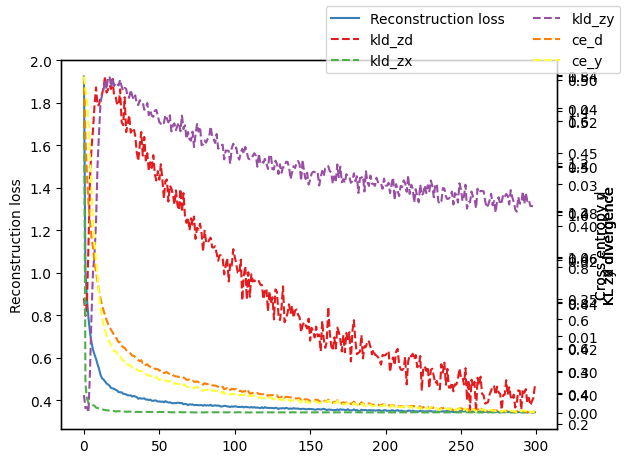

In [14]:
from matplotlib import cm

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()
ax6 = ax1.twinx()
ax1.plot(histroy['recon_loss'], label='Reconstruction loss', color=cm.Set1.colors[1])
ax2.plot(histroy['kld_zd'], label='kld_zd', color=cm.Set1.colors[0], linestyle='dashed')
ax3.plot(histroy['kld_zx'], label='kld_zx', color=cm.Set1.colors[2], linestyle='dashed')
ax4.plot(histroy['kld_zy'], label='kld_zy', color=cm.Set1.colors[3], linestyle='dashed')
ax5.plot(histroy['ce_d'], label='ce_d', color=cm.Set1.colors[4], linestyle='dashed')
ax6.plot(histroy['ce_y'], label='ce_y', color=cm.Set1.colors[5], linestyle='dashed')
ax1.set_ylabel('Reconstruction loss')
ax2.set_ylabel('KL zd divergence')
ax3.set_ylabel('KL zx divergence')
ax4.set_ylabel('KL zy divergence')
ax5.set_ylabel('Cross entropy d')
ax6.set_ylabel('Cross entropy y')
fig.legend(ncol=2)

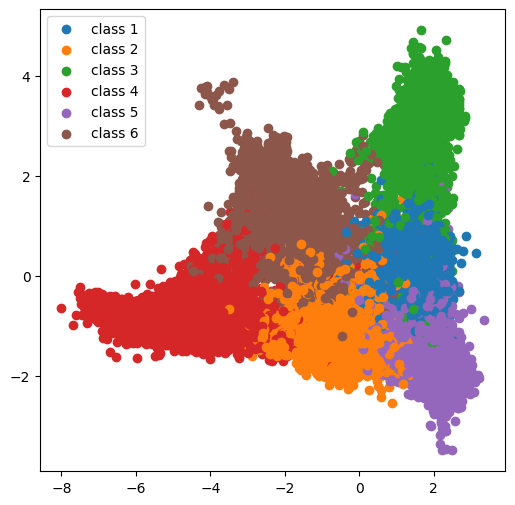

In [50]:
# 動作固有の潜在空間を可視化

fig, ax = plt.subplots(figsize=(6,6))

cm = plt.get_cmap("tab10")
added_labels = []

for batch_idx, (data, label, saubject) in enumerate(data_loader):
    data = data.to(device)
    data = data.view(-1, 45*4)
    # print(data.size())
    mean_zy, _ = model.qzy(data)
    mean_zy = mean_zy.cpu().detach().numpy()

    for k in range(6):
        cluster_idx = np.where(label.detach().numpy() == k)[0]
        if k not in added_labels:
            ax.scatter(mean_zy[cluster_idx, 0], mean_zy[cluster_idx, 1], color=cm(k), label = f'class {k+1}')
            added_labels.append(k)
        else:
            ax.scatter(mean_zy[cluster_idx, 0], mean_zy[cluster_idx, 1], color=cm(k))
ax.legend()
plt.show()
      

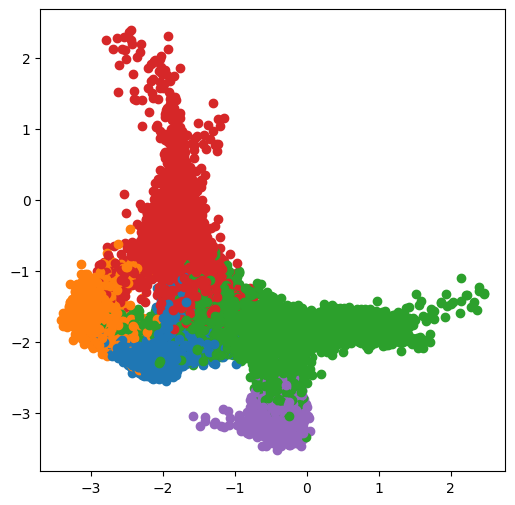

In [24]:
#　被験者固有の潜在空間を可視化 
# 動作固有の潜在空間を可視化

fig, ax = plt.subplots(figsize=(6,6))

cm = plt.get_cmap("tab10")

for batch_idx, (data, label, subject) in enumerate(data_loader):
    data = data.to(device)
    data = data.view(-1, 45*4)
    # print(data.size())
    mean_zd, _ = model.qzd(data)
    mean_zd = mean_zd.cpu().detach().numpy()

    for k in range(5):
        cluster_idx = np.where(subject.detach().numpy() == k)[0]
        ax.scatter(mean_zd[cluster_idx, 0], mean_zd[cluster_idx, 1], color=cm(k))

In [28]:
# テストデータ(被験者６)に対する潜在空間の可視化

stacked_data = np.empty((0, time_width, n_channel))
class_label = np.empty(0)

fname = f'./data/furui_lab/extracted/1.0Hz/sub6/'
for c in range(n_class):
    # print(f'sub : {s+1} class_label : {c+1}')
    # stacked_data_trial = np.empty((0, time_width, n_channel))
    for t in range(n_trial):
        read_data = np.loadtxt(f'{fname}class{c+1}trial{t+1}.csv', usecols= [0,1,2,3],delimiter=',')
        # read_data = read_data[::down_sampling_rate]
        read_data = read_data.reshape(-1, time_width, n_channel)
        read_class_label = np.full(len(read_data),c)
        
        stacked_data = np.vstack([stacked_data, read_data])
        class_label = np.hstack([class_label, read_class_label])

In [35]:
print(stacked_data[0][1])
X, _ = normalize_train_data(stacked_data, 'norm', 'each')
print(X[0][1])
train_dataset = reshape_dataset_to_tensor(X=X, y=class_label, s=None,  structure='static')

# dataset = TensorDataset(X, class_label, subject_label) 



data_loader = DataLoader(train_dataset, batch_size=256, 
              shuffle=True, drop_last=True)

[1.2214579e-05 4.3043334e-05 1.4088766e-04 1.2014875e-05]
[0.22661243 0.06730503 0.5150884  0.04991508]


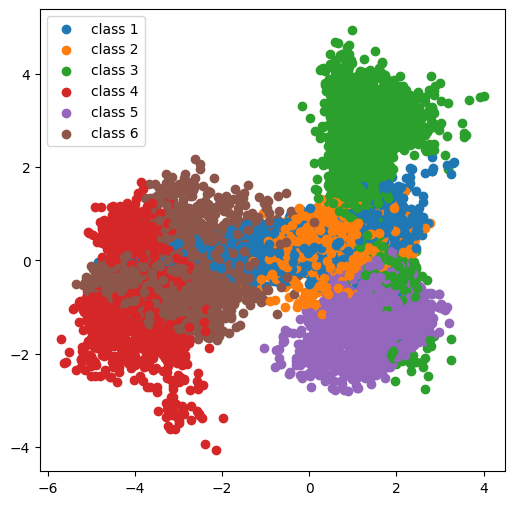

In [45]:
# 動作固有の潜在空間を可視化

fig, ax = plt.subplots(figsize=(6,6))

cm = plt.get_cmap("tab10")
added_labels = []

for batch_idx, (data, label) in enumerate(data_loader):
    data = data.to(device)
    data = data.view(-1, 45*4)
    # print(data.size())
    mean_zy, _ = model.qzy(data)
    mean_zy = mean_zy.cpu().detach().numpy()

    for k in range(6):
        cluster_idx = np.where(label.detach().numpy() == k)[0]
        if k not in added_labels:
            ax.scatter(mean_zy[cluster_idx, 0], mean_zy[cluster_idx, 1], color=cm(k), label = f'class {k+1}')
            added_labels.append(k)
        else:
            ax.scatter(mean_zy[cluster_idx, 0], mean_zy[cluster_idx, 1], color=cm(k))
    
ax.legend()
plt.show()

